In [1]:
import sys, os
import numpy as np
import pandas as pd

from modules import featureEngineering,hyperParameter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings('always')

thresholdImportance = 0.005

# Path of data

In [2]:
path2TrainingData = 'originalData/training_data.csv'
path2TestData = 'originalData/test_data.csv'

# Load into DataFrames

In [3]:
originalTrain = pd.read_csv(path2TrainingData)
originalTest = pd.read_csv(path2TestData)

In [4]:
originalTrain.shape

(2572, 99)

# Get the target from train dataframe

In [5]:
import ast
originalTarget = []
for individual in originalTrain.iloc[:,-1]:
    originalTarget.append((ast.literal_eval(individual))[1:-1]) 

# Add duplicate data (EnhancedData)
* Training data is enhanced from 2572 records to 5144 records
* Testing data is enhanced from 749 records to 1498 records

In [6]:
enhancedTest = featureEngineering.addDuplicateDF(originalTest)
enhancedTrain = featureEngineering.addDuplicateDF(originalTrain)
enhancedTrainTraget = featureEngineering.addDuplicateTarget(originalTarget)

In [7]:
enhancedTrain.to_csv(r'enhancedData/Train/trainEnhancedV1-AddedDuplicates.csv')
enhancedTest.to_csv(r'enhancedData/Test/testEnhancedV1-AddedDuplicates.csv')

In [8]:
enhancedTrain.shape

(5144, 98)

# Additional features (EnhancedData Version2)
* Number of features are enhanced from 96 to 190. The additional features are derived from the original features.

In [9]:
enhancedTrainV2 = featureEngineering.addFeatures(enhancedTrain)
enhancedTestV2 = featureEngineering.addFeatures(enhancedTest)

In [10]:
enhancedTrainV2.to_csv(r'enhancedData/Train/trainEnhancedV2-AddedDuplicates&Features.csv')
enhancedTestV2.to_csv(r'enhancedData/Test/testEnhancedV2-AddedDuplicates&Features.csv')

In [11]:
enhancedTrainV2.shape

(5144, 190)

In [12]:
# Assign features
trainAllFeatures = enhancedTrainV2.iloc[:,2:]
testAllFeatures = enhancedTestV2.iloc[:,2:]
targets = enhancedTrainTraget

# Random Forest Feature Selection 
* Apply on 190 features to know the importance of each

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


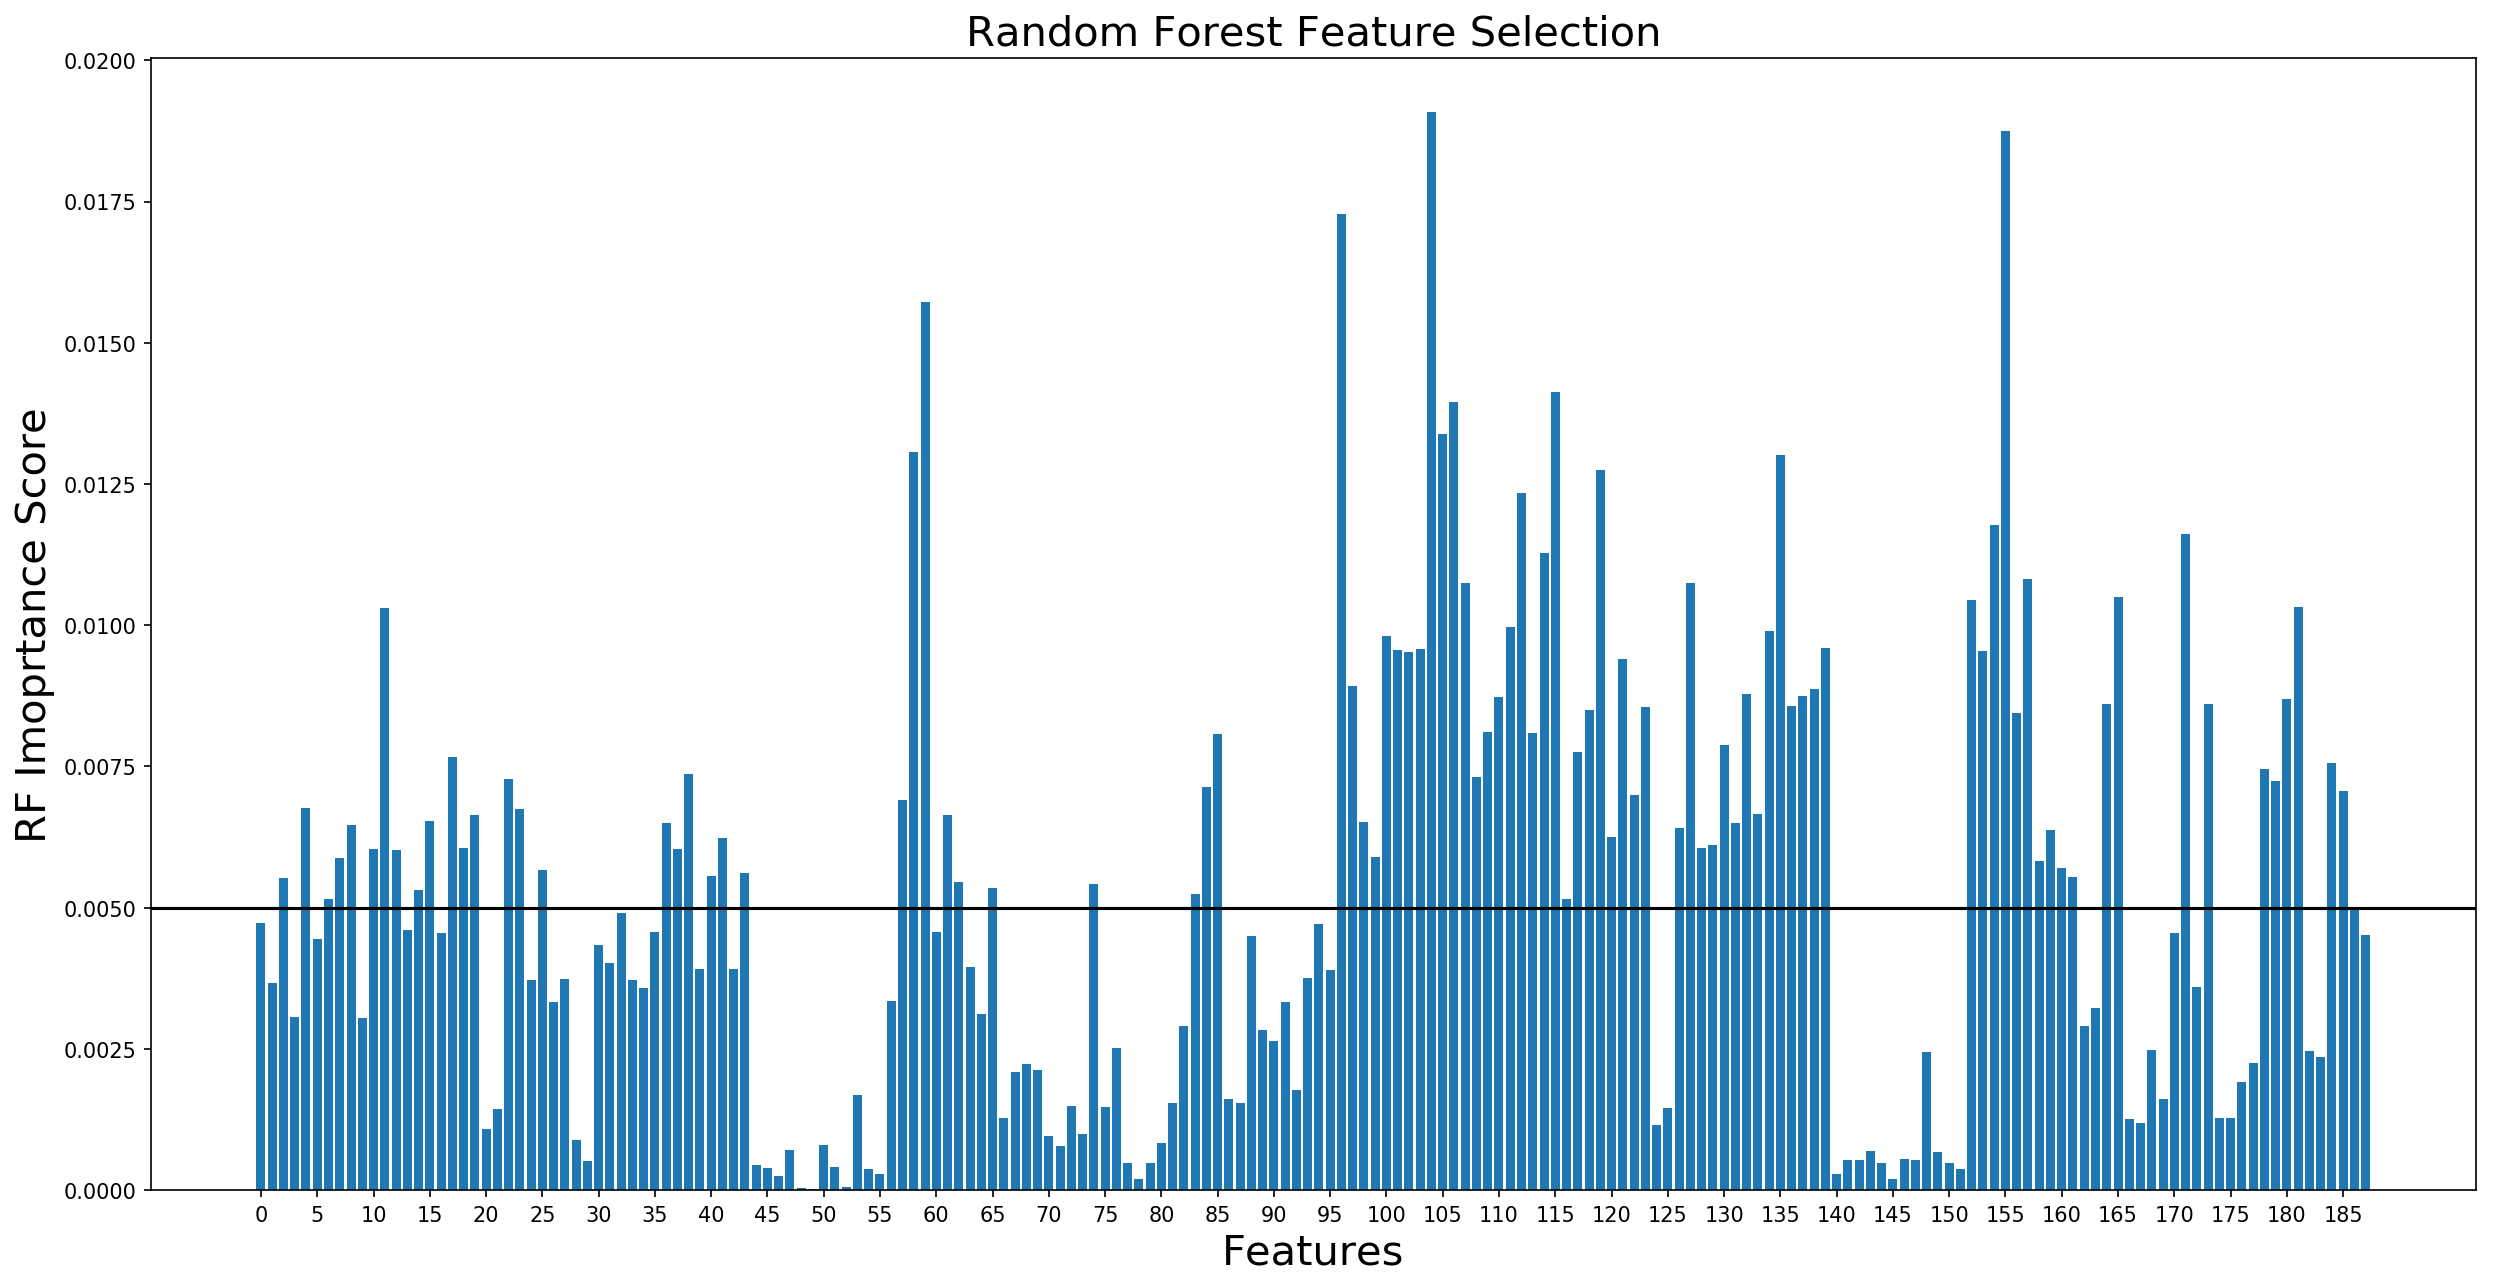

In [13]:
summary = featureEngineering.rfFeatureSelection(trainAllFeatures, targets, summary = True, plot = True)

# Assign the most important features (FinalData)
* goodIndex is the indices of all the features with score > threshold (0.005). Finalize these indices for train and test features.
* 78 features are important out of 190

In [14]:
goodIndex = featureEngineering.getGoodIndex(summary)
FinalTrainFeatures = trainAllFeatures.iloc[:,goodIndex]
FinalTestFeatures = testAllFeatures.iloc[:,goodIndex]

In [15]:
FinalTrainFeatures.to_csv(r'enhancedData/Train/trainEnhancedFinal-AddedDuplicates&Features&OnlyImpFeatures.csv')
FinalTestFeatures.to_csv(r'enhancedData/Test/testEnhancedFinal-AddedDuplicates&Features&OnlyImpFeatures.csv')

In [16]:
FinalTrainFeatures.shape

(5144, 78)

# Normalize the features with mean = 0 and SD = 1

In [17]:
x = FinalTrainFeatures - FinalTrainFeatures.mean(axis = 0)
X = x / x.std(axis = 0)

# Train, Test and Validation Split
* 30% Test Set
* 10% Validation Set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.3)

In [19]:
X_train2, X_dev, y_train2, y_dev = train_test_split(X_train, y_train, test_size=0.1)

In [20]:
# Best HyperParameters. Add values here to perform hyperparameter tuning.
max_features        = ['log2']
max_depth           = [None]
n_estimators        = [50]   
criterion           = ['gini']
min_samples_leaf    = [1]
min_samples_split   = [2]
bootstrap = ['True']

import itertools
hyperParameters = list(itertools.product(max_features,max_depth,n_estimators,criterion,        
                                          min_samples_leaf,min_samples_split,bootstrap))

In [21]:
# getOnlyModel=False to get RF results 
rf = hyperParameter.RFmodel(X,targets,hyperParameters,plotCM = True,getOnlyModel=True)

# Prediction on test dataset

### Normalize the data

In [22]:
t = FinalTrainFeatures - FinalTrainFeatures.mean(axis = 0)
testActual = t / t.std(axis = 0)

In [24]:
testPredicted = rf.predict(testActual)

### Add pure element

In [25]:
n = testPredicted.shape[0]
Pures = np.ones((n, 1))
testPredictandPure = np.hstack((Pures, testPredicted))
testPredictandPure = pd.DataFrame(np.hstack((testPredictandPure, Pures)))
testPredictandPure.columns = ['a','b','c','d','e','f','g','h','i','j','k']

In [26]:
finalPredicts = pd.DataFrame('['+testPredictandPure.astype(str).apply(lambda x: ','.join(x), axis=1)+']')
finalPredicts.columns = ['stabilityVec']

In [28]:
finalPredictsDF = pd.concat([enhancedTestV2.iloc[:,:2],FinalTestFeatures,finalPredicts],axis=1)

### Save the final file

In [29]:
finalPredictsDF.to_csv(r'results/predictions_enhnacedTestData.csv')